In [99]:
import os
import pickle as pkl
import pandas as pd
import numpy as np

from pydeseq2.utils import build_design_matrix
#from pydeseq2.dds import DeseqDataSet
#from pydeseq2.default_inference import DefaultInference
#from pydeseq2.ds import DeseqStats

In [39]:
# Loading the data from package

In [101]:
# Test simulated data
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/datasets/"
counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_counts_cnv_v2.csv"), index_col=0)
counts_df = counts_df.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_v2.csv"), index_col=0)
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv_v2.csv"), index_col=0)
cnv = cnv.T

In [454]:
# Test real data
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA/lung_cancer/LUAD/"
counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_test_4.csv"), index_col=0)
counts_df = counts_df.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_4.csv"), index_col=0)
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv_test_4.csv"), index_col=0)
cnv = cnv.T

In [4]:
#design_matrix = build_design_matrix(
    #metadata=metadata,
    #design_factors="condition",
    #expanded=False,
    #intercept=True
#)
#design_matrix = design_matrix.values
#design_matrix.shape

In [4]:
#num_vars = design_matrix.shape[1]
#X = design_matrix

In [103]:
from dds import pydeseq2CN_data
from inference import Inference
from def_inference import DefInference
import utils_pydeseq2CN

In [105]:
inference = DefInference(n_cpus=8)
dds = pydeseq2CN_data(
    counts=counts_df,
    metadata=metadata,
    cnv=cnv,
    design_factors="condition",
    inference=inference
)

In [107]:
dds.fit_size_factors()

Fitting size factors...
... done in 0.02 seconds.



In [109]:
dds.obsm["size_factors"]

array([0.67757283, 0.77241505, 0.97451723, 0.98471297, 1.08100712,
       0.67227724, 0.86964993, 0.87418082, 0.92174837, 1.12968067,
       0.73981026, 1.13534478, 1.14612132, 1.23972742, 0.89408448,
       1.06409745, 0.78884774, 1.19630956, 0.93868625, 0.68708624,
       1.06462389, 1.06301636, 0.83759593, 0.88976792, 0.82386927,
       0.83198542, 1.40940848, 1.05467806, 1.53731219, 0.94263736,
       1.38727537, 1.44919526, 0.99290959, 1.08858899, 1.15564116,
       1.59024613, 1.60026705, 1.51044553, 1.02295709, 1.59862046])

In [111]:
dds.fit_genewise_dispersions()

Fitting dispersions...
... done in 0.31 seconds.



In [113]:
dds.fit_dispersion_trend()

Fitting dispersion trend curve...
... done in 0.07 seconds.



In [115]:
#dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]

array([0.81510231, 1.38090664, 0.36432796, ..., 0.19048856, 0.22656774,
       0.18547492])

In [117]:
dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)

logres_prior=0.3817147618374133, sigma_prior=0.32767385579971714


In [119]:
dds.fit_MAP_dispersions()

Fitting MAP dispersions...
... done in 0.40 seconds.



ValueError: NumPy boolean array indexing assignment cannot assign 3000 input values to the 52 output values where the mask is true

In [121]:
dds.varm["MAP_dispersions"]

array([0.48865113, 0.57093024, 0.26898864, ..., 0.16537119, 0.09936846,
       0.13695002])

In [123]:
dds.varm["dispersions"]

array([0.48865113, 0.57093024, 0.26898864, ..., 0.16537119, 0.09936846,
       0.13695002])

In [40]:
#design_matrix = dds.obsm["design_matrix"]
#design_matrix = design_matrix.values

In [16]:
#beta = (6.47867033, 0.06064821)
#beta = np.array(beta)
#beta

In [17]:
#beta.shape[0]
#design_matrix.shape[1]

In [22]:
#if beta.shape[0] != design_matrix.shape[1]:
    #beta = beta.reshape(design_matrix.shape[1], -1)

In [125]:
dds.fit_LFC()

Fitting LFCs...
... done in 0.22 seconds.



In [127]:
dds.varm["LFC"]

,intercept,condition_B_vs_A
g1,4.665699,-0.248053
g2,4.017145,-0.364503
g3,5.891979,-0.331702
g4,3.787267,-0.205916
g5,8.514027,-0.106714
...,...,...
g2996,6.821653,-0.387471
g2997,6.421891,-0.143277
g2998,7.225582,-0.202493
g2999,6.319957,-0.281775


In [39]:
# Check relevant data properties
#print("Counts shape:", counts_df.shape)
#print("CNV shape:", cnv.shape)
#print("non_zero_idx shape:", non_zero_idx.shape)
#print("non_zero_idx content (first 10):", non_zero_idx[:10])

In [40]:
# Check compatibility
#if isinstance(non_zero_idx, (np.ndarray, pd.Series)):
    #if non_zero_idx.max() >= counts_df.shape[1]:
        #print("Error: Index exceeds data dimensions.")
    #else:
        #print("Indexing looks valid.")

In [41]:
#if isinstance(counts_df, pd.DataFrame):
    #print(counts_df.columns)
#if isinstance(cnv, pd.DataFrame):
    #print(cnv.columns)

In [ ]:
# Statistical test

In [129]:
import dds_stat
from dds_stat import pydeseq2CN_Stats

In [131]:
# Statistical analysis
stat_res = pydeseq2CN_Stats(dds, alpha=0.05, independent_filter=True)

In [133]:
stat_res.run_wald_test()

Running Wald tests...
... done in 0.11 seconds.



In [135]:
stat_res.p_values

g1       0.266895
g2       0.134208
g3       0.044384
g4       0.472586
g5       0.494822
           ...   
g2996    0.001528
g2997    0.208394
g2998    0.116215
g2999    0.005142
g3000    0.014471
Length: 3000, dtype: float64

In [137]:
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

/opt/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1588: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = np.linalg.lstsq(A, b)[0]


g1            NaN
g2            NaN
g3            NaN
g4            NaN
g5       0.587800
           ...   
g2996    0.033353
g2997    0.329164
g2998    0.232375
g2999    0.051438
g3000    0.086623
Name: 7, Length: 3000, dtype: float64

In [139]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
g1       69.228403       -0.357865  0.322331 -1.110242  0.266895       NaN
g2       36.927188       -0.525867  0.351114 -1.497711  0.134208       NaN
g3      228.395255       -0.478545  0.238029 -2.010448  0.044384       NaN
g4       30.375880       -0.297075  0.413593 -0.718277  0.472586       NaN
g5     3631.769449       -0.153956  0.225525 -0.682659  0.494822  0.587800
...            ...             ...       ...       ...       ...       ...
g2996  1184.020645       -0.559002  0.176376 -3.169375  0.001528  0.033353
g2997   900.702459       -0.206705  0.164313 -1.257993  0.208394  0.329164
g2998  2015.142171       -0.292136  0.185972 -1.570860  0.116215  0.232375
g2999   768.076926       -0.406516  0.145288 -2.798008  0.005142  0.051438
g3000  2602.269963       -0.413741  0.169194 -2.445365  0.014471  0.086623

[3000 rows x 6 columns]


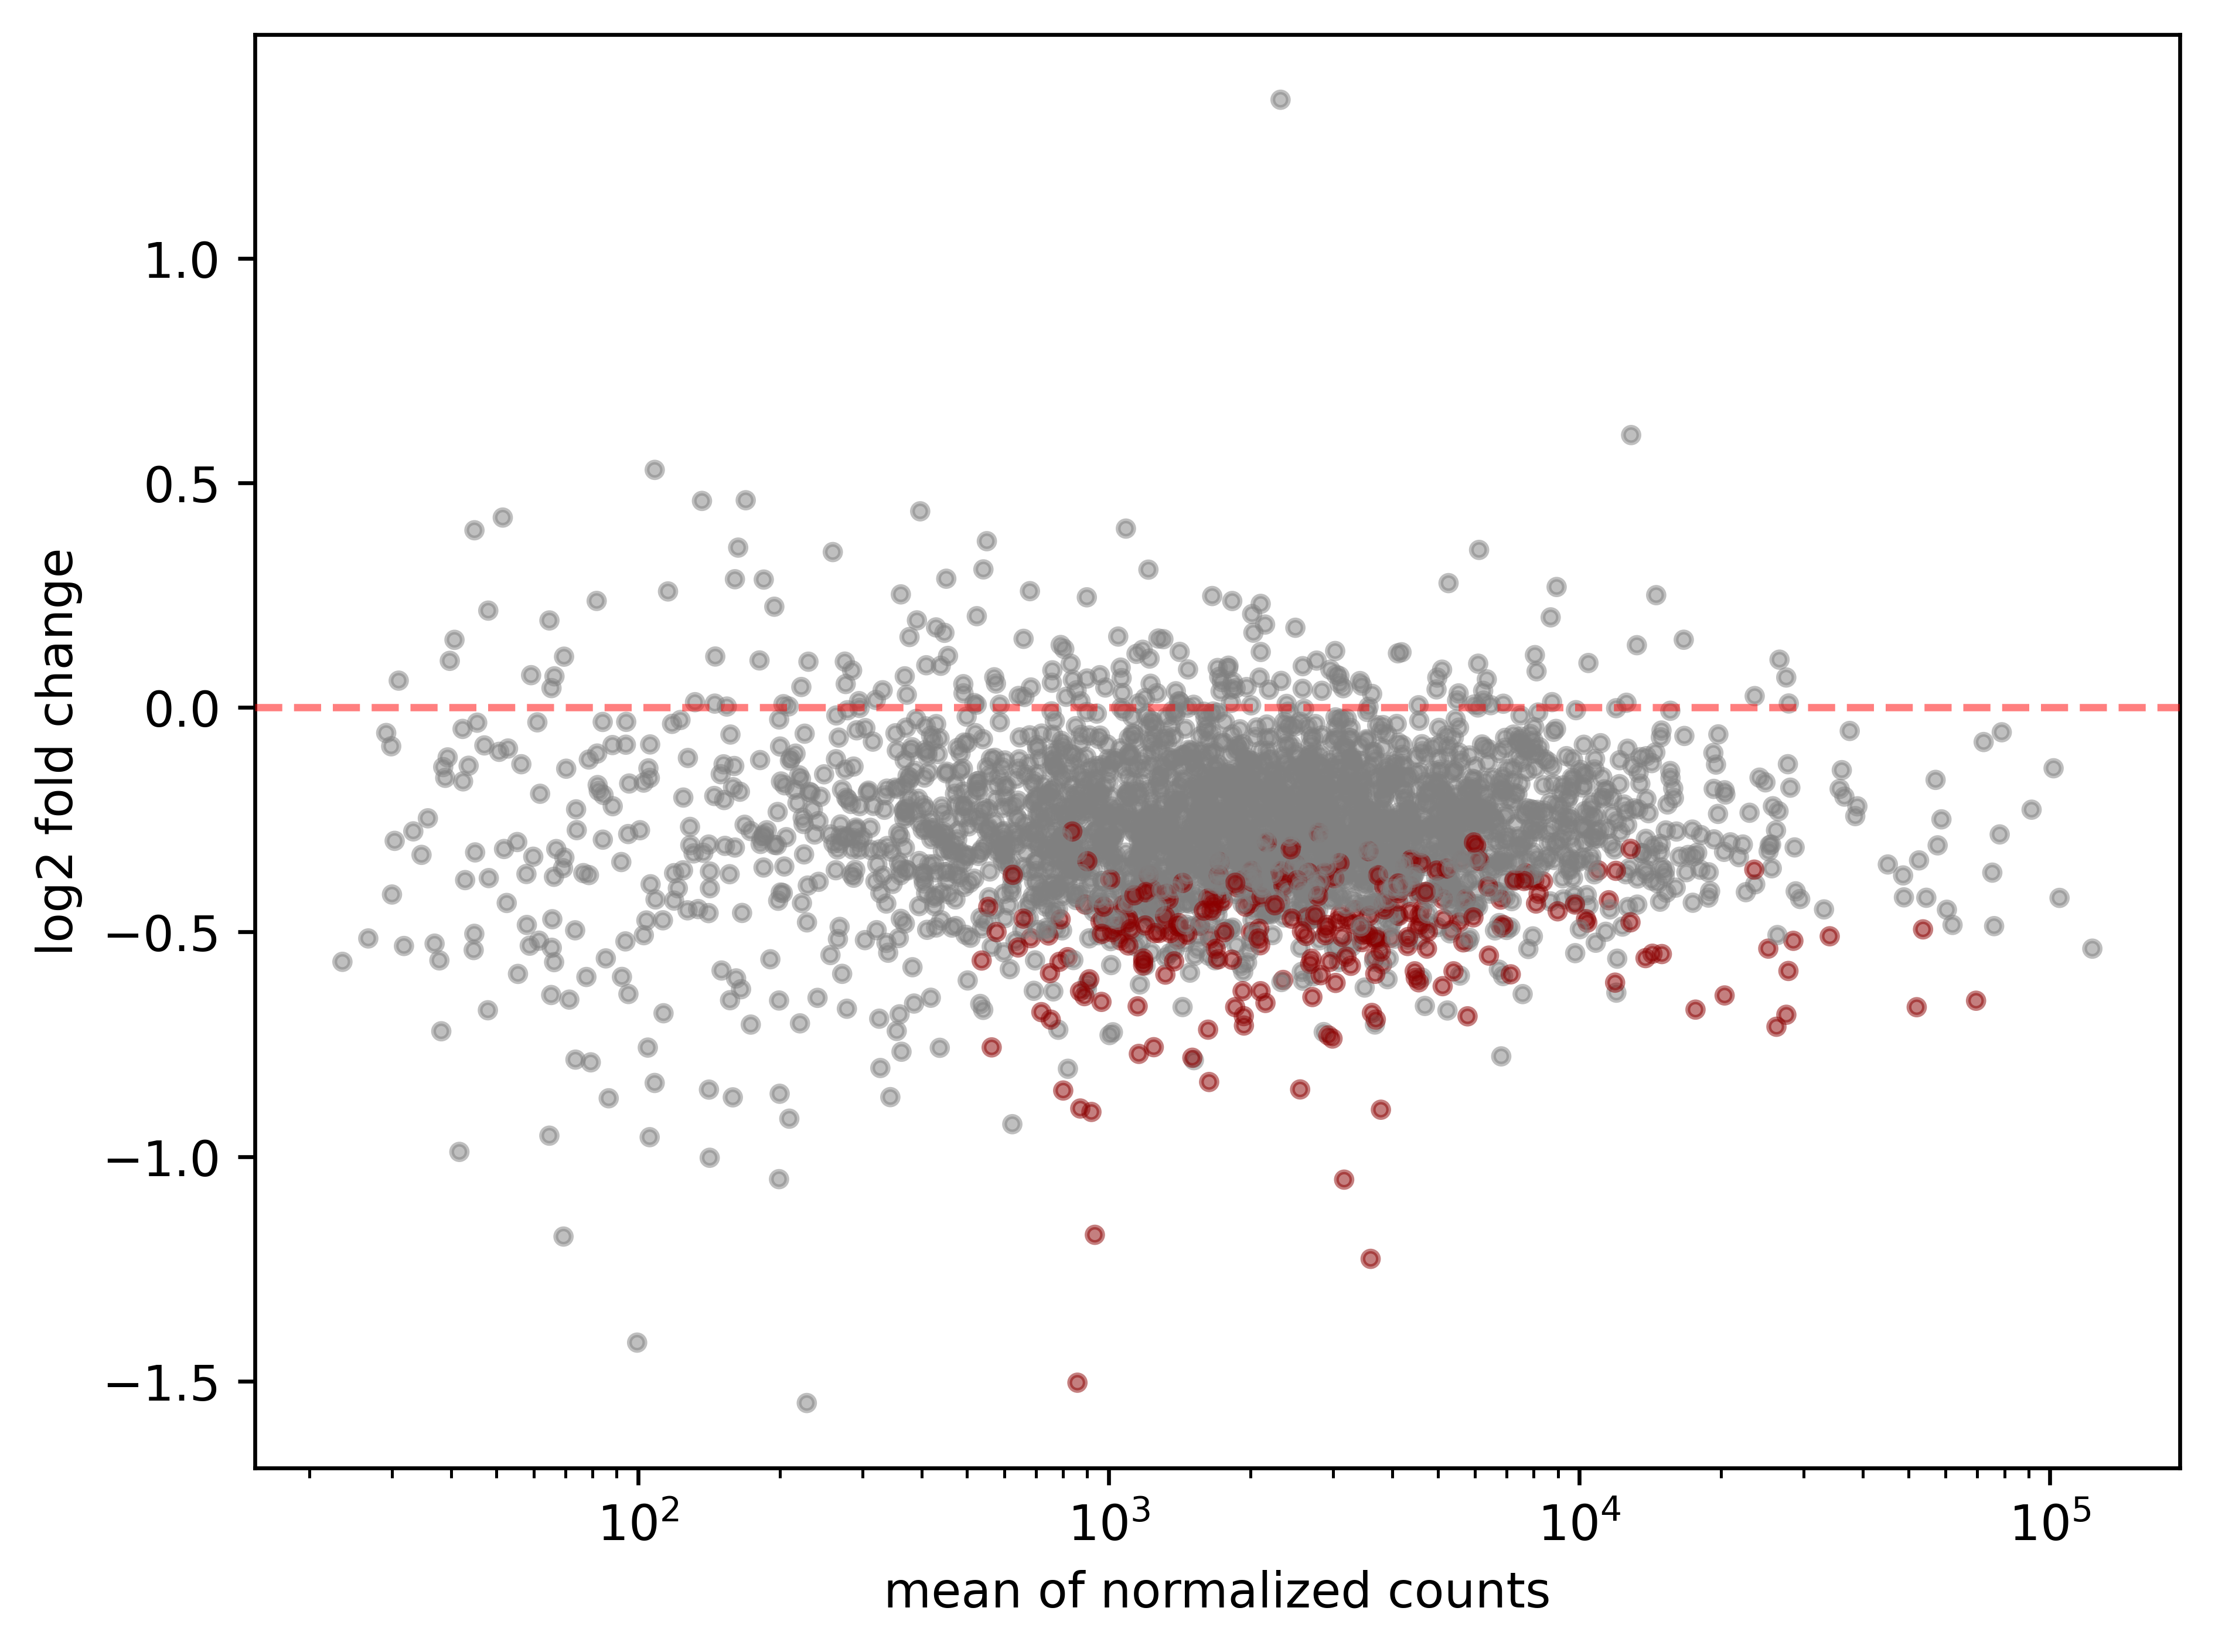

In [141]:
stat_res.plot_MA(s=10)

In [143]:
stat_res.lfc_shrink(coeff="condition_B_vs_A")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
g1       69.228403       -0.095677  0.222351 -1.110242  0.266895       NaN
g2       36.927188       -0.131663  0.252171 -1.497711  0.134208       NaN
g3      228.395255       -0.258096  0.239459 -2.010448  0.044384       NaN
g4       30.375880       -0.049701  0.223003 -0.718277  0.472586       NaN
g5     3631.769449       -0.073558  0.178440 -0.682659  0.494822  0.587800
...            ...             ...       ...       ...       ...       ...
g2996  1184.020645       -0.461929  0.181701 -3.169375  0.001528  0.033353
g2997   900.702459       -0.122495  0.149035 -1.257993  0.208394  0.329164
g2998  2015.142171       -0.165135  0.173064 -1.570860  0.116215  0.232375
g2999   768.076926       -0.327860  0.146929 -2.798008  0.005142  0.051438
g3000  2602.269963       -0.316439  0.172581 -2.445365  0.014471  0.086623

[3000 rows x 6 columns]


... done in 0.42 seconds.



In [147]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
g1       69.228403       -0.095677  0.222351 -1.110242  0.266895       NaN
g2       36.927188       -0.131663  0.252171 -1.497711  0.134208       NaN
g3      228.395255       -0.258096  0.239459 -2.010448  0.044384       NaN
g4       30.375880       -0.049701  0.223003 -0.718277  0.472586       NaN
g5     3631.769449       -0.073558  0.178440 -0.682659  0.494822  0.587800
...            ...             ...       ...       ...       ...       ...
g2996  1184.020645       -0.461929  0.181701 -3.169375  0.001528  0.033353
g2997   900.702459       -0.122495  0.149035 -1.257993  0.208394  0.329164
g2998  2015.142171       -0.165135  0.173064 -1.570860  0.116215  0.232375
g2999   768.076926       -0.327860  0.146929 -2.798008  0.005142  0.051438
g3000  2602.269963       -0.316439  0.172581 -2.445365  0.014471  0.086623

[3000 rows x 6 columns]


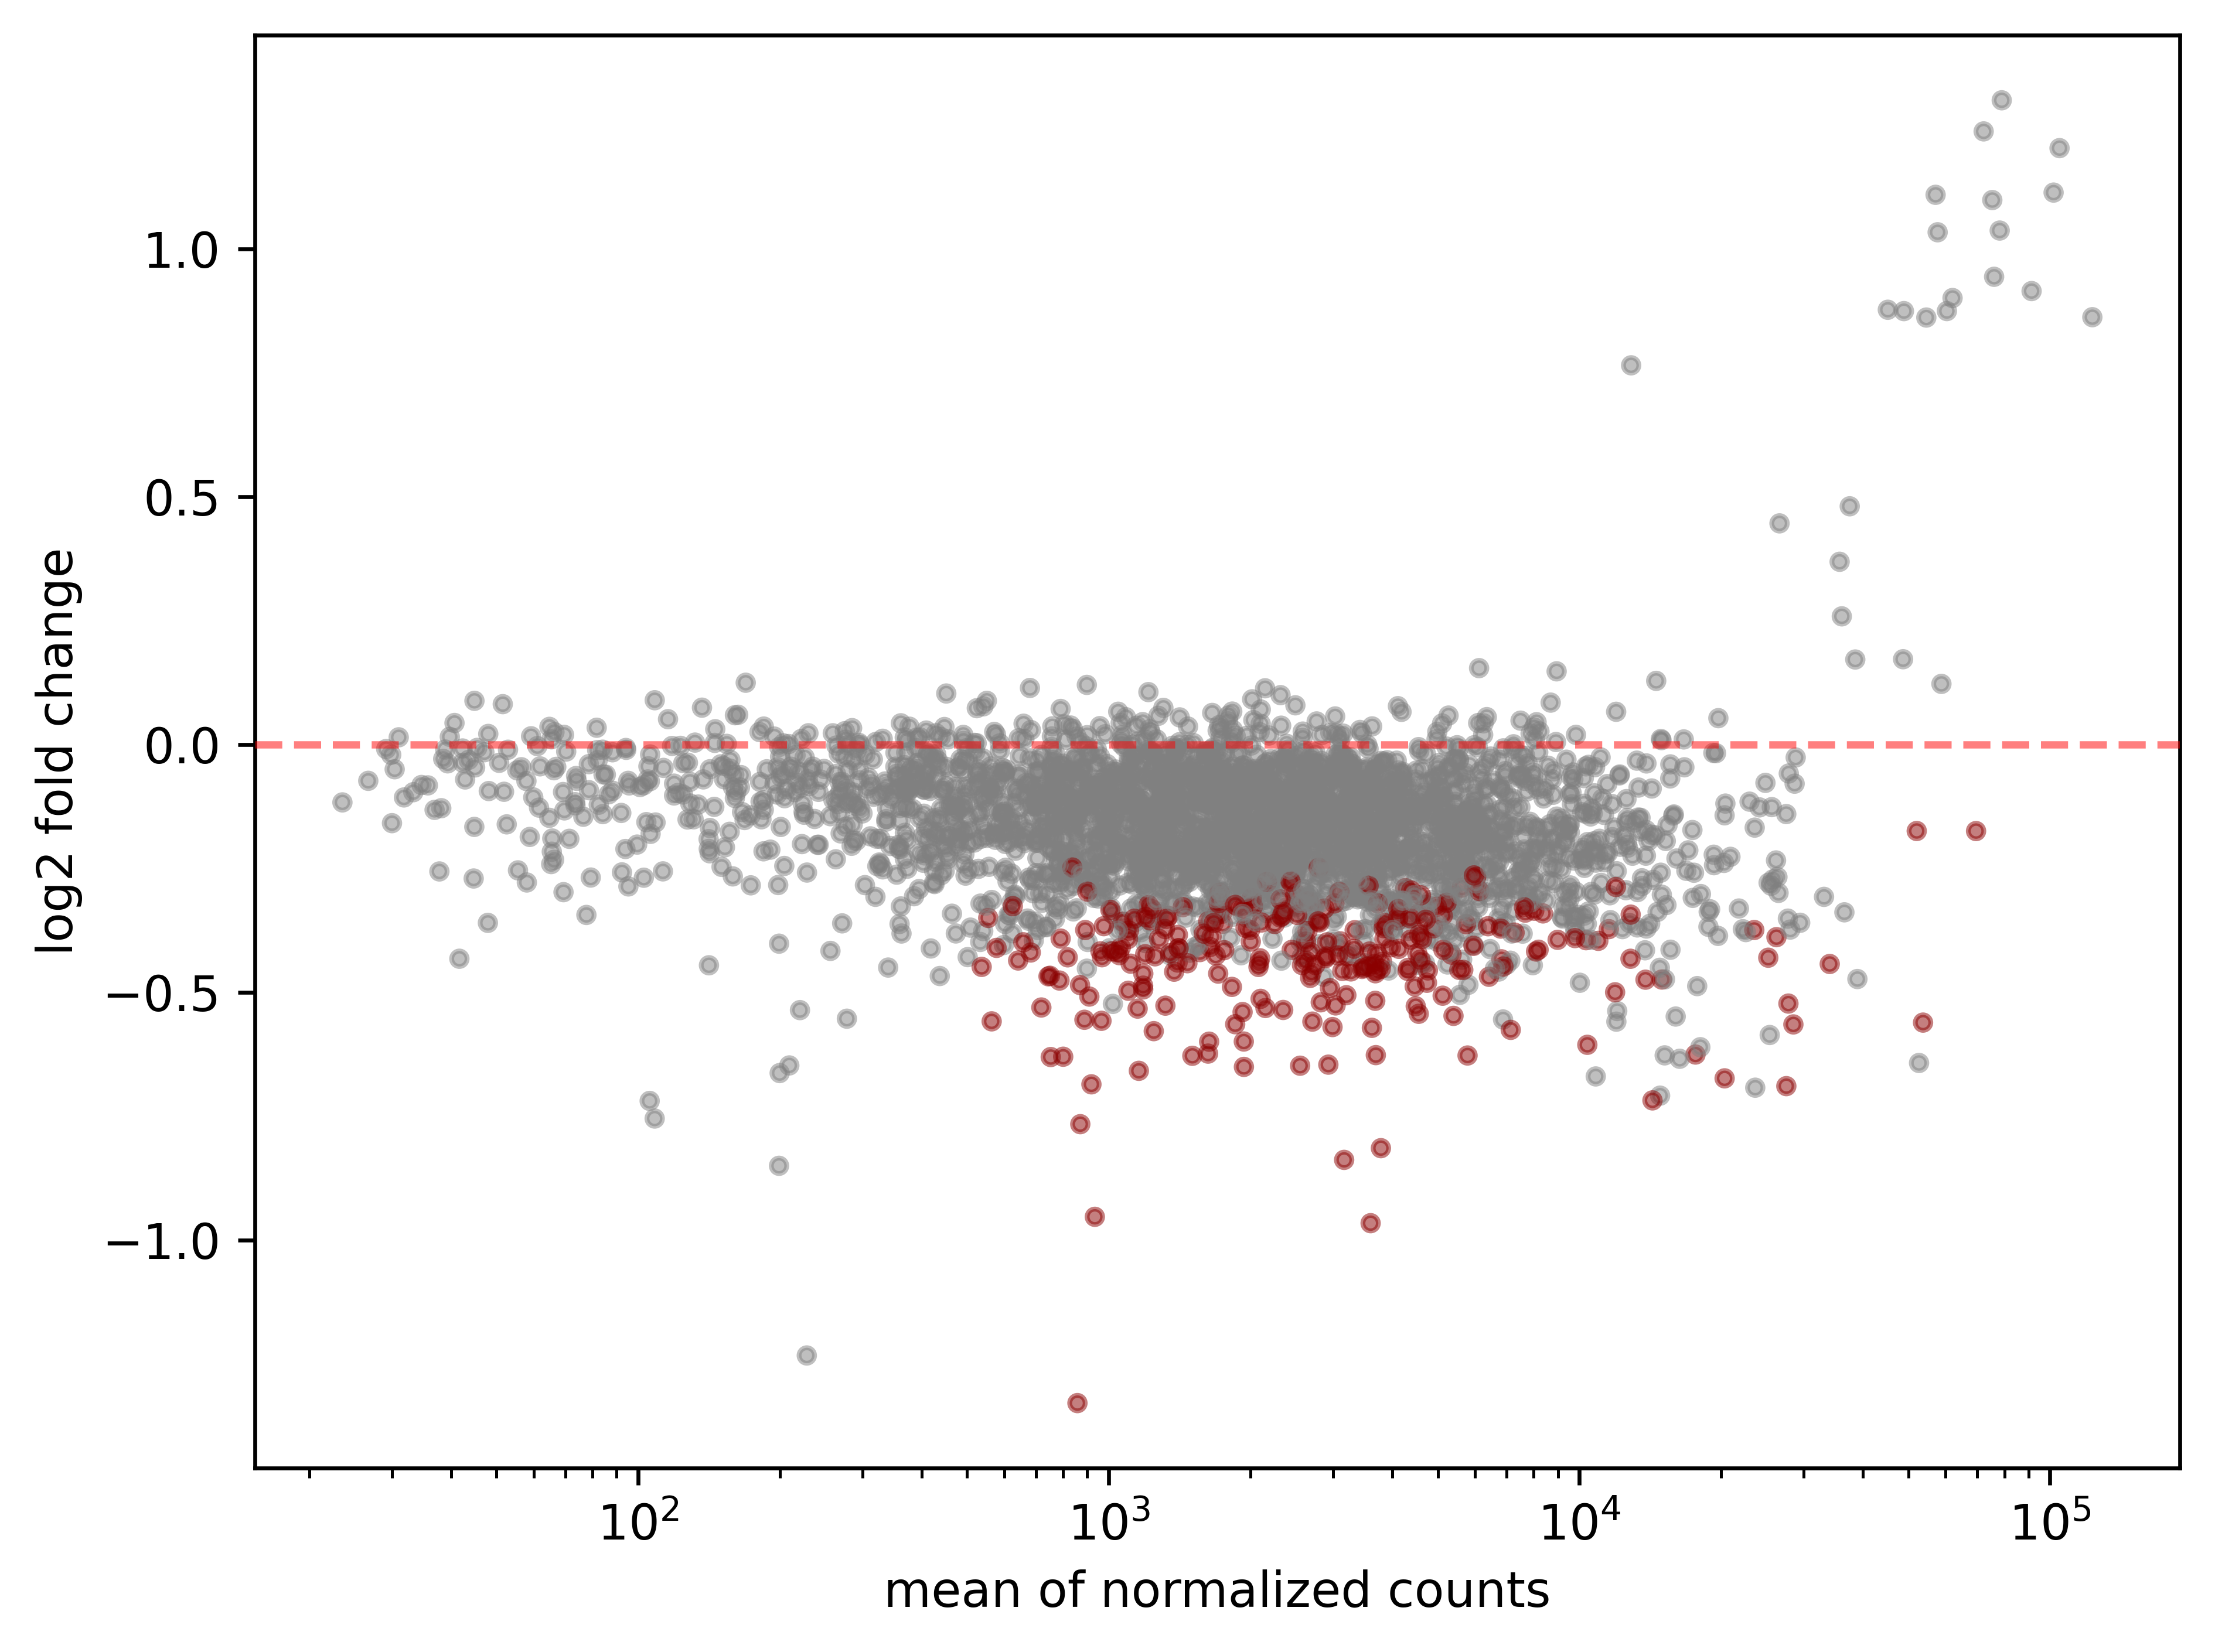

In [149]:
stat_res.plot_MA(s=10)

In [97]:
OUTPUT_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/results"
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "res_CNaware_sim2.csv"))